#### 3) Переписать эту программу на PyTorch:  
```python
model = tf.keras.models.Sequential([  
    tf.keras.layers.Flatten(input_shape=(28,28)),  
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(10, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy')
```

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cuda:0"
# device = "cpu"

In [3]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

In [4]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                          shuffle=True, num_workers=12)

In [5]:
trainset.data.size()

torch.Size([60000, 28, 28])

In [6]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=120,
                                         shuffle=True, num_workers=12)

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


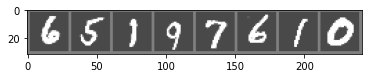

tensor([6, 5, 1, 9, 7, 6, 1, 0])


In [9]:
imshow(torchvision.utils.make_grid(images[:8,:]))
print(labels[:8])

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten(1, -1)
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2)
        x = self.linear2(x)
        x = F.softmax(x)
        return x

In [11]:
model = Net()
if device == "cuda:0":
    model.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [13]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if device == "cpu":
            inputs, labels = data
        elif device == "cuda:0":
#             inputs, labels = data[0].to(device), F.one_hot(data[1], 10).to(device)
            inputs, labels = data[0].to(device), data[1].to(device)
        else:
            print("DEVICE ERROR")
            break

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 499))
            running_loss = 0.0
print('Finished Training')

/home/bocharick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


[1,   500] loss: 1.822
[2,   500] loss: 1.642
Finished Training


In [14]:
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        if device == "cpu":
            inputs, labels = data
        elif device == "cuda:0":
            inputs, labels = data[0].to(device), data[1].to(device)
        break

In [15]:
y_pred = model(inputs).cpu().detach().numpy()

/home/bocharick/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


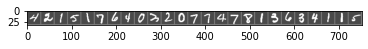

y:      [4 2 1 5 1 7 6 4 0 3 2 0 7 7 4 7 8 1 3 6 3 4 1 1 5]
y_pred: [4 2 1 5 1 7 6 4 0 2 2 0 7 7 4 7 8 1 5 6 3 4 1 1 5]


In [16]:
imshow(torchvision.utils.make_grid(inputs.cpu()[:25,:], 25))
print("y:     ",labels.cpu().numpy()[:25])
print("y_pred:", y_pred.argmax(1)[:25])